In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9086
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  F7UPK8AX_14_07_47
NN-MODEL FILENAME:  ./models/F7UPK8AX_14_07_47_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, p_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]  = boundary
    
    
    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_MIN,  C_POS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_MIN,  C_VEL_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_MIN,  P_ANG_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_MIN,  P_VEL_MAX,  HI_GRAIN)

    my_borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = p_table
    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, my_borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = (node_id%N_ACTIONS)#np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, my_borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)

#     GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    new_max = np.array([exp_rec[:,i].max() for i in range(N_STATES)])
    new_min = np.array([exp_rec[:,i].min() for i in range(N_STATES)])
    

    if iteration >= 4: 

        old_max = np.array(boundary[:4])
        old_min = np.array(boundary[4:])

        newboundary_max = old_max
        newboundary_min = old_min

        damper = 0.6
        for i in range(N_STATES):
            newboundary_max[i] = new_max[i] if new_max[i] >= old_max[i] else (old_max[i]*damper+new_max[i]*(1-damper))
            newboundary_min[i] = new_min[i] if new_min[i] <= old_min[i] else (old_min[i]*damper+new_min[i]*(1-damper))
            
            MARGIN = 2*(newboundary_max - newboundary_min)/HI_GRAIN

        newboundary = np.concatenate((newboundary_max + MARGIN,
                                      newboundary_min - MARGIN))
    else:
        MARGIN = 2*(new_max - new_min)/HI_GRAIN
        newboundary = np.concatenate((new_max + MARGIN,
                                      new_min + MARGIN))

        
#   # CLAMP STATE VALUE BORDERS
    ##############################################
    newboundary[0] = clamp(C_POS_ABS_MIN, newboundary[0], C_POS_ABS_MAX)
    newboundary[4] = clamp(C_POS_ABS_MIN, newboundary[4], C_POS_ABS_MAX) 

    newboundary[1] = clamp(C_VEL_ABS_MIN, newboundary[1], C_VEL_ABS_MAX)
    newboundary[5] = clamp(C_VEL_ABS_MIN, newboundary[5], C_VEL_ABS_MAX) 

    newboundary[2] = clamp(P_ANG_ABS_MIN, newboundary[2], P_ANG_ABS_MAX)
    newboundary[6] = clamp(P_ANG_ABS_MIN, newboundary[6], P_ANG_ABS_MAX) 

    newboundary[3] = clamp(P_VEL_ABS_MIN, newboundary[3], P_VEL_ABS_MAX)
    newboundary[7] = clamp(P_VEL_ABS_MIN, newboundary[7], P_VEL_ABS_MAX)
    
#     newboundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
#                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1305.53 MiB, increment: 1085.62 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table
q_table_list = [node_q_table]* NO_OF_NODES




ITERATION # 0
TOTAL EXPERIENCE GENERATED:   17419
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 62
TOTAL SERIAL TIMESTEPS:   17419
TOTAL PARALLEL TIMESTEPS: 62


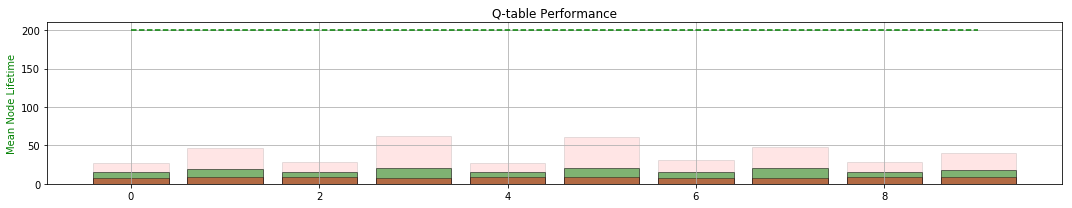

MEMORY COUNTER:  17419
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 515.080	LOSS : 477.552	LOSS : 483.459	LOSS : 483.573	LOSS : 483.032	LOSS : 457.189	LOSS : 480.903	LOSS : 456.206	LOSS : 492.882	LOSS : 467.211	LOSS : 430.347	LOSS : 450.817	LOSS : 437.742	LOSS : 438.834	LOSS : 434.270	LOSS : 433.910	LOSS : 430.778	LOSS : 417.383	LOSS : 403.236	LOSS : 420.943	
Validating... MEAN TIME:  116.195
LOSS : 421.132	LOSS : 413.041	LOSS : 414.270	LOSS : 405.677	LOSS : 415.975	LOSS : 395.771	LOSS : 397.619	LOSS : 419.162	LOSS : 419.753	LOSS : 420.148	LOSS : 426.322	LOSS : 399.904	LOSS : 408.458	LOSS : 391.304	LOSS : 401.059	LOSS : 403.411	LOSS : 396.334	LOSS : 395.979	LOSS : 400.419	LOSS : 406.268	
Validating... MEAN TIME:  127.665
LOSS : 399.254	LOSS : 389.779	LOSS : 397.829	LOSS : 385.171	LOSS : 400.739	LOSS : 396.322	LOSS : 387.937	LOSS : 385.549	LOSS : 392.709	LOSS : 399.167	LOSS : 389.393	LOSS : 407.126	LOSS : 381.437	LOSS : 408.615	LOSS : 387.364	LOSS : 404.992	LOSS : 3

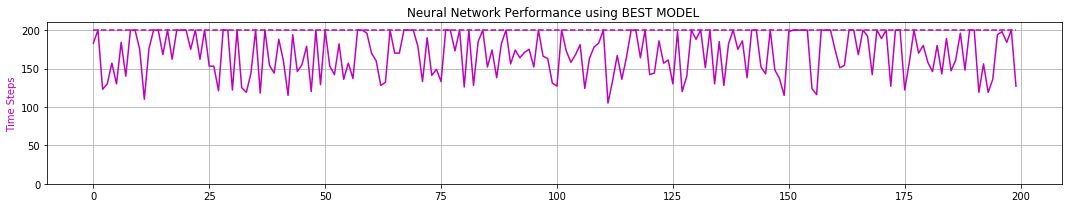

0 -max- [ 0.064  0.333  0.222  3.082]
0 -min- [-0.216 -1.879 -0.036  0.013]

peak memory: 1351.97 MiB, increment: 1064.23 MiB
Quantization TIME:  0.02 minutes
1 -max- [ 0.452  2.124  0.105  0.945]
1 -min- [-0.082 -0.827 -0.194 -2.585]

peak memory: 1362.42 MiB, increment: 1035.74 MiB
Quantization TIME:  0.02 minutes
2 -max- [ 0.063  0.504  0.222  2.703]
2 -min- [-0.196 -1.628 -0.035  0.001]

peak memory: 1381.36 MiB, increment: 1034.80 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 0.319  1.898  0.100  0.990]
3 -min- [-0.091 -0.857 -0.194 -2.551]

peak memory: 1439.98 MiB, increment: 1074.00 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 0.062  0.498  0.222  2.856]
4 -min- [-0.201 -1.682 -0.035  0.041]

peak memory: 1420.55 MiB, increment: 1035.16 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 0.466  2.105  0.127  0.736]
5 -min- [-0.197 -0.771 -0.193 -2.685]

peak memory: 1441.32 MiB, increment: 1036.50 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 0.064  0.419  0.222  2.833]
6 -min- 

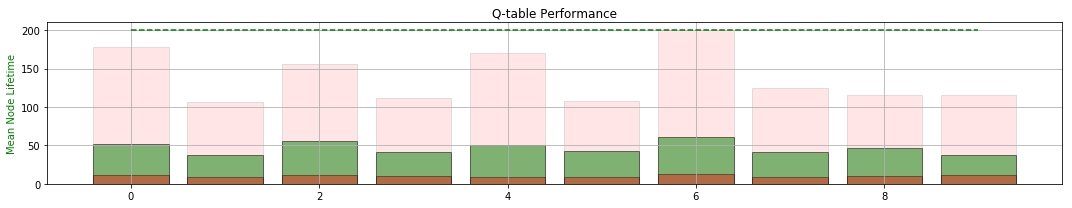

MEMORY COUNTER:  63840
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 388.681	LOSS : 394.312	LOSS : 371.638	LOSS : 384.755	LOSS : 375.878	LOSS : 369.165	LOSS : 384.907	LOSS : 390.065	LOSS : 375.393	LOSS : 362.458	LOSS : 355.345	LOSS : 340.085	LOSS : 348.844	LOSS : 354.891	LOSS : 342.997	LOSS : 341.508	LOSS : 345.280	LOSS : 344.132	LOSS : 330.058	LOSS : 330.781	
Validating... MEAN TIME:  176.845
LOSS : 345.736	LOSS : 330.893	LOSS : 321.862	LOSS : 344.844	LOSS : 326.182	LOSS : 325.214	LOSS : 338.679	LOSS : 326.125	LOSS : 343.176	LOSS : 307.540	LOSS : 305.278	LOSS : 322.652	LOSS : 324.836	LOSS : 321.998	LOSS : 330.774	LOSS : 331.979	LOSS : 319.102	LOSS : 340.123	LOSS : 336.797	LOSS : 317.178	
Validating... MEAN TIME:  180.03
LOSS : 319.824	LOSS : 327.803	LOSS : 327.363	LOSS : 310.847	LOSS : 310.843	LOSS : 322.327	LOSS : 320.619	LOSS : 323.043	LOSS : 315.449	LOSS : 308.855	LOSS : 308.792	LOSS : 316.054	LOSS : 327.954	LOSS : 314.118	LOSS : 315.791	LOSS : 311.095	LOSS : 32

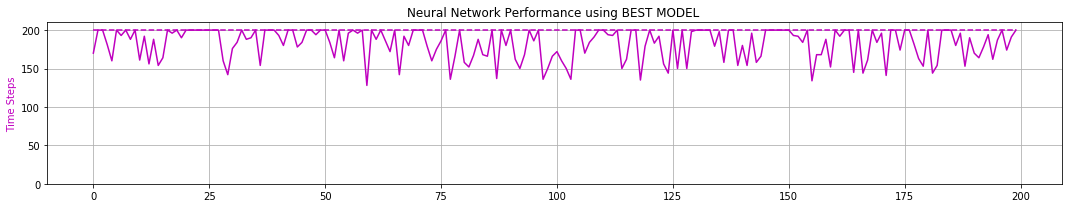

0 -max- [ 1.162  2.051  0.223  2.590]
0 -min- [-0.262 -1.410 -0.060 -1.257]

peak memory: 1560.64 MiB, increment: 1035.10 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 0.279  1.577  0.061  1.517]
1 -min- [-0.949 -1.541 -0.197 -2.305]

peak memory: 1619.40 MiB, increment: 1054.64 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 1.110  1.837  0.230  2.631]
2 -min- [-0.759 -1.410 -0.188 -1.318]

peak memory: 1639.02 MiB, increment: 1054.59 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 0.298  1.565  0.062  1.522]
3 -min- [-0.974 -1.690 -0.196 -2.489]

peak memory: 1652.05 MiB, increment: 1048.19 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 0.794  1.818  0.223  2.771]
4 -min- [-0.266 -1.391 -0.049 -1.110]

peak memory: 1639.43 MiB, increment: 1015.89 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 0.273  1.565  0.062  1.486]
5 -min- [-0.926 -1.520 -0.196 -2.328]

peak memory: 1697.46 MiB, increment: 1054.50 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 1.007  2.029  0.230  2.542]
6 -min- 

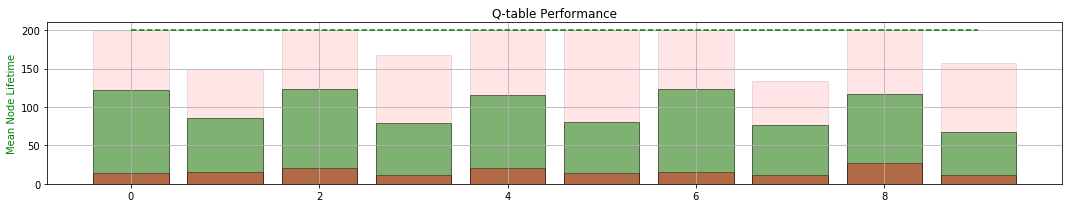

MEMORY COUNTER:  162795
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 233.648	LOSS : 219.323	LOSS : 222.990	LOSS : 214.178	LOSS : 217.540	LOSS : 220.813	LOSS : 213.618	LOSS : 192.862	LOSS : 195.493	LOSS : 185.881	LOSS : 202.446	LOSS : 196.774	LOSS : 180.302	LOSS : 212.647	LOSS : 198.893	LOSS : 205.862	LOSS : 192.178	LOSS : 193.686	LOSS : 203.810	LOSS : 205.345	
Validating... MEAN TIME:  195.56
LOSS : 193.666	LOSS : 207.078	LOSS : 195.784	LOSS : 196.846	LOSS : 214.164	LOSS : 180.711	LOSS : 187.142	LOSS : 190.711	LOSS : 198.922	LOSS : 196.411	LOSS : 184.972	LOSS : 203.079	LOSS : 186.710	LOSS : 180.828	LOSS : 197.931	LOSS : 191.159	LOSS : 185.954	LOSS : 184.701	LOSS : 185.491	LOSS : 197.097	
Validating... MEAN TIME:  196.895
LOSS : 187.240	LOSS : 196.017	LOSS : 193.127	LOSS : 184.069	LOSS : 170.172	LOSS : 181.316	LOSS : 185.823	LOSS : 207.660	LOSS : 188.094	LOSS : 195.177	LOSS : 203.320	LOSS : 188.315	LOSS : 203.793	LOSS : 207.874	LOSS : 194.811	LOSS : 186.667	LOSS : 2

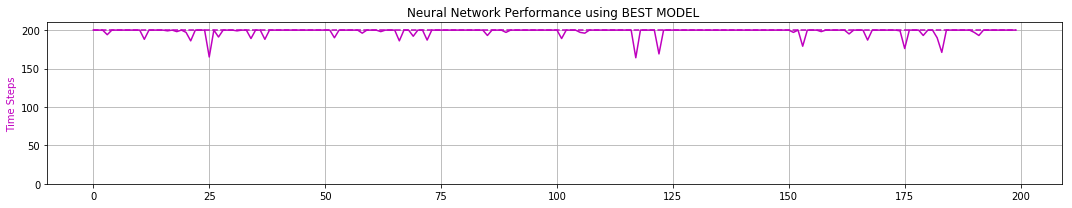

0 -max- [ 2.072  2.631  0.230  3.289]
0 -min- [-1.248 -1.830 -0.188 -1.766]

peak memory: 1726.46 MiB, increment: 976.95 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 0.283  1.525  0.128  2.173]
1 -min- [-1.414 -2.248 -0.193 -2.115]

peak memory: 1726.46 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 1.858  2.394  0.230  2.766]
2 -min- [-1.638 -2.169 -0.188 -1.751]

peak memory: 1726.46 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 0.293  1.734  0.113  2.091]
3 -min- [-1.459 -2.205 -0.194 -2.307]

peak memory: 1726.46 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 2.023  2.697  0.230  2.402]
4 -min- [-1.474 -2.188 -0.188 -1.904]

peak memory: 1726.46 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 0.344  1.804  0.111  2.152]
5 -min- [-1.424 -2.080 -0.194 -2.549]

peak memory: 1726.46 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 1.944  2.488  0.230  2.773]
6 -min- [-1.31

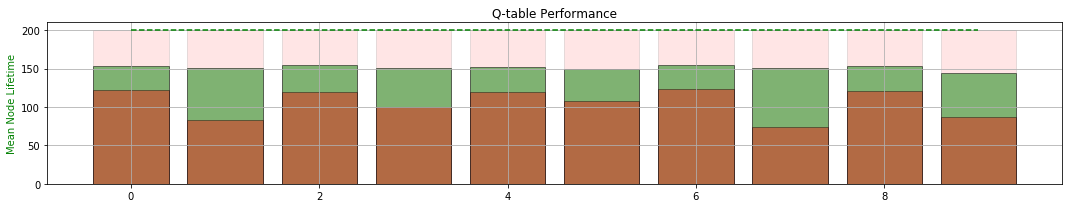

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 70.023	LOSS : 61.257	LOSS : 74.893	LOSS : 67.015	LOSS : 79.115	LOSS : 68.397	LOSS : 72.329	LOSS : 68.362	LOSS : 74.653	LOSS : 67.457	LOSS : 60.487	LOSS : 69.857	LOSS : 73.726	LOSS : 72.355	LOSS : 71.347	LOSS : 69.669	LOSS : 71.632	LOSS : 75.050	LOSS : 78.404	LOSS : 68.242	
Validating... MEAN TIME:  115.695
LOSS : 66.740	LOSS : 73.396	LOSS : 67.985	LOSS : 78.595	LOSS : 62.258	LOSS : 70.822	LOSS : 69.136	LOSS : 71.977	LOSS : 81.082	LOSS : 73.970	LOSS : 72.745	LOSS : 71.235	LOSS : 74.599	LOSS : 69.984	LOSS : 67.931	LOSS : 67.230	LOSS : 63.592	LOSS : 70.066	LOSS : 76.733	LOSS : 73.837	
Validating... MEAN TIME:  196.885
LOSS : 65.196	LOSS : 76.547	LOSS : 66.721	LOSS : 70.089	LOSS : 67.413	LOSS : 63.690	LOSS : 65.445	LOSS : 64.167	LOSS : 64.847	LOSS : 69.055	LOSS : 68.554	LOSS : 72.235	LOSS : 67.615	LOSS : 67.367	LOSS : 67.130	LOSS : 70.624	LOSS : 67.050	LOSS : 68.438	LOSS : 71.773	LOSS : 63.223	
Valida

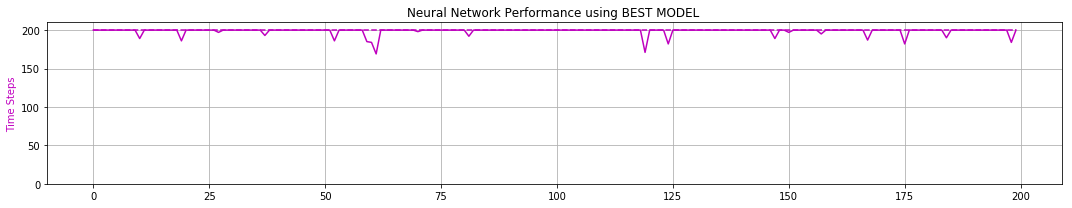

0 -max- [ 1.320  1.556  0.152  1.737]
0 -min- [-2.004 -2.626 -0.192 -1.573]

peak memory: 1793.41 MiB, increment: 976.97 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 0.700  1.160  0.110  1.600]
1 -min- [-1.999 -2.250 -0.194 -1.228]

peak memory: 1793.41 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 0.522  1.135  0.106  1.368]
2 -min- [-2.082 -2.431 -0.194 -1.411]

peak memory: 1793.41 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 1.154  1.576  0.143  1.797]
3 -min- [-1.989 -2.758 -0.193 -1.848]

peak memory: 1793.41 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 1.170  1.379  0.124  1.711]
4 -min- [-2.220 -3.128 -0.193 -1.469]

peak memory: 1793.41 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 1.233  1.346  0.125  1.676]
5 -min- [-1.849 -2.564 -0.193 -1.455]

peak memory: 1793.41 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 0.611  1.298  0.110  1.751]
6 -min- [-1.98

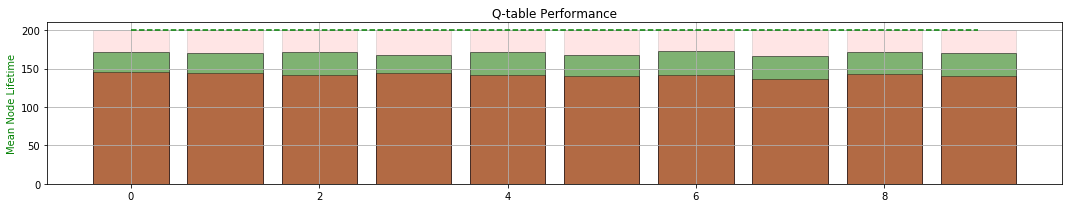

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 53.957	LOSS : 64.736	LOSS : 58.144	LOSS : 55.286	LOSS : 64.019	LOSS : 56.384	LOSS : 56.603	LOSS : 64.530	LOSS : 62.934	LOSS : 59.161	LOSS : 57.487	LOSS : 60.482	LOSS : 57.725	LOSS : 71.131	LOSS : 58.870	LOSS : 59.844	LOSS : 68.327	LOSS : 59.797	LOSS : 58.571	LOSS : 65.404	
Validating... MEAN TIME:  115.62
LOSS : 58.891	LOSS : 57.586	LOSS : 56.155	LOSS : 52.509	LOSS : 62.183	LOSS : 59.929	LOSS : 60.182	LOSS : 57.767	LOSS : 61.973	LOSS : 51.267	LOSS : 53.586	LOSS : 61.534	LOSS : 56.667	LOSS : 52.313	LOSS : 61.892	LOSS : 60.561	LOSS : 58.472	LOSS : 56.452	LOSS : 50.804	LOSS : 59.122	
Validating... MEAN TIME:  143.08
LOSS : 53.069	LOSS : 58.087	LOSS : 51.950	LOSS : 56.317	LOSS : 55.514	LOSS : 52.678	LOSS : 51.984	LOSS : 51.946	LOSS : 59.568	LOSS : 58.662	LOSS : 48.170	LOSS : 53.297	LOSS : 54.300	LOSS : 53.189	LOSS : 51.953	LOSS : 53.911	LOSS : 52.343	LOSS : 52.328	LOSS : 57.179	LOSS : 56.590	
Validati

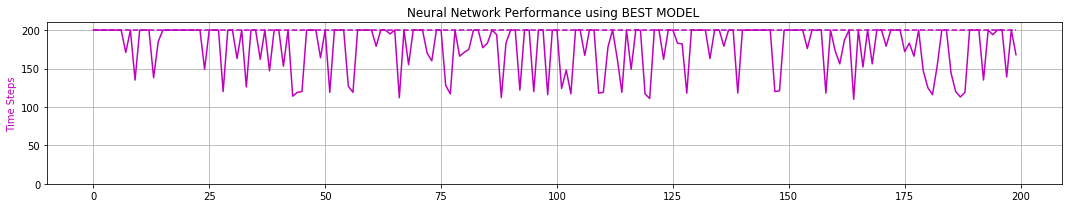

0 -max- [ 2.144  3.848  0.216  4.720]
0 -min- [-2.600 -4.666 -0.250 -4.590]

peak memory: 1739.76 MiB, increment: 995.58 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 1.802  3.632  0.197  4.665]
1 -min- [-2.600 -4.701 -0.250 -4.416]

peak memory: 1818.49 MiB, increment: 977.13 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 1.820  3.632  0.198  4.690]
2 -min- [-2.600 -4.657 -0.250 -4.447]

peak memory: 1778.79 MiB, increment: 1015.00 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 1.826  3.701  0.192  4.671]
3 -min- [-2.600 -4.660 -0.250 -4.460]

peak memory: 1818.61 MiB, increment: 977.09 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 1.853  3.637  0.209  4.777]
4 -min- [-2.600 -4.719 -0.250 -4.428]

peak memory: 1818.61 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 1.810  3.632  0.197  4.666]
5 -min- [-2.600 -4.659 -0.250 -4.451]

peak memory: 1838.02 MiB, increment: 976.79 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 1.819  3.632  0.209  4.714]
6 -min- [-2.6

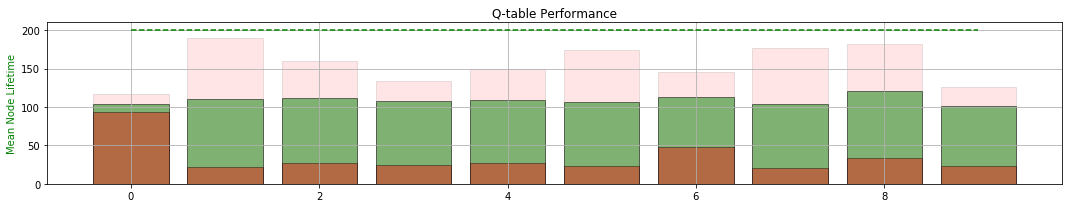

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 98.127	LOSS : 91.804	LOSS : 89.592	LOSS : 85.018	LOSS : 72.750	LOSS : 81.003	LOSS : 75.271	LOSS : 69.185	LOSS : 61.737	LOSS : 67.236	LOSS : 74.833	LOSS : 70.899	LOSS : 73.734	LOSS : 65.523	LOSS : 71.410	LOSS : 75.001	LOSS : 67.833	LOSS : 73.820	LOSS : 73.689	LOSS : 68.861	
Validating... MEAN TIME:  95.81
LOSS : 69.650	LOSS : 70.352	LOSS : 65.038	LOSS : 61.281	LOSS : 73.711	LOSS : 66.295	LOSS : 66.858	LOSS : 58.031	LOSS : 68.493	LOSS : 65.651	LOSS : 63.401	LOSS : 65.175	LOSS : 60.834	LOSS : 66.074	LOSS : 66.727	LOSS : 70.021	LOSS : 74.870	LOSS : 69.568	LOSS : 70.600	LOSS : 76.663	
Validating... MEAN TIME:  95.805
LOSS : 64.210	LOSS : 63.905	LOSS : 66.612	LOSS : 78.294	LOSS : 68.122	LOSS : 69.455	LOSS : 67.412	LOSS : 72.446	LOSS : 58.589	LOSS : 65.642	LOSS : 65.264	LOSS : 60.811	LOSS : 71.199	LOSS : 53.656	LOSS : 69.221	LOSS : 71.512	LOSS : 65.609	LOSS : 63.725	LOSS : 65.188	LOSS : 73.805	
Validatin

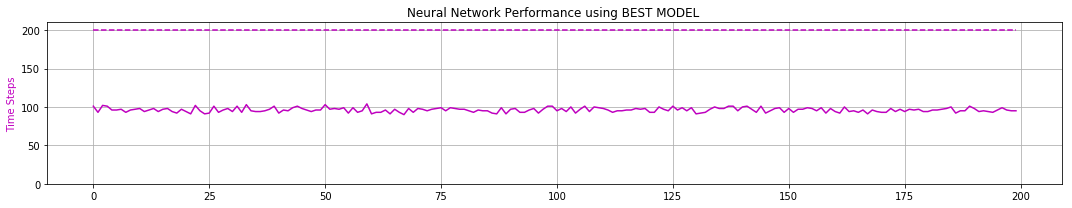

0 -max- [ 1.552  2.887  0.168  3.495]
0 -min- [-2.600 -4.381 -0.250 -3.410]

peak memory: 1838.06 MiB, increment: 976.81 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 1.341  2.816  0.158  3.392]
1 -min- [-2.600 -4.395 -0.250 -3.381]

peak memory: 1916.19 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 1.361  2.758  0.161  3.413]
2 -min- [-2.600 -4.354 -0.250 -3.374]

peak memory: 1838.06 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 1.356  2.800  0.154  3.489]
3 -min- [-2.600 -4.387 -0.250 -3.401]

peak memory: 1838.06 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 1.390  2.815  0.171  3.528]
4 -min- [-2.600 -4.402 -0.250 -3.362]

peak memory: 1916.19 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 1.345  2.759  0.158  3.477]
5 -min- [-2.600 -4.366 -0.250 -3.457]

peak memory: 1916.19 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 1.370  2.741  0.168  3.536]
6 -min- [-2.60

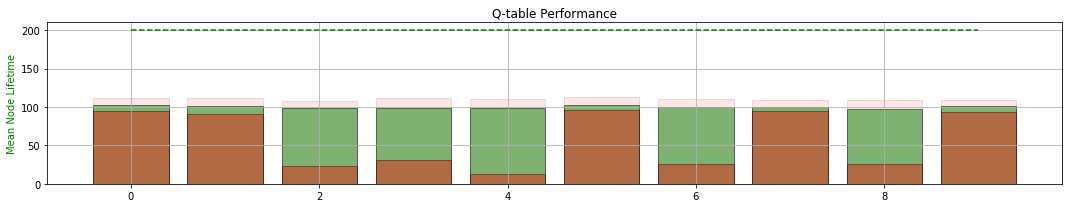

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 113.518	LOSS : 97.105	LOSS : 89.630	LOSS : 94.979	LOSS : 78.468	LOSS : 94.115	LOSS : 86.751	LOSS : 91.000	LOSS : 86.062	LOSS : 83.198	LOSS : 79.414	LOSS : 85.937	LOSS : 89.944	LOSS : 82.995	LOSS : 85.388	LOSS : 104.385	LOSS : 90.039	LOSS : 85.215	LOSS : 83.167	LOSS : 104.239	
Validating... MEAN TIME:  82.275
LOSS : 86.697	LOSS : 86.417	LOSS : 81.461	LOSS : 72.676	LOSS : 89.395	LOSS : 94.188	LOSS : 95.783	LOSS : 95.571	LOSS : 88.919	LOSS : 99.851	LOSS : 92.621	LOSS : 87.757	LOSS : 83.578	LOSS : 87.221	LOSS : 91.865	LOSS : 91.301	LOSS : 80.444	LOSS : 81.068	LOSS : 83.805	LOSS : 84.502	
Validating... MEAN TIME:  122.64
LOSS : 93.603	LOSS : 85.099	LOSS : 93.297	LOSS : 85.175	LOSS : 87.907	LOSS : 93.289	LOSS : 84.346	LOSS : 97.798	LOSS : 82.222	LOSS : 95.280	LOSS : 85.789	LOSS : 83.693	LOSS : 77.098	LOSS : 89.529	LOSS : 85.679	LOSS : 95.353	LOSS : 73.026	LOSS : 88.020	LOSS : 85.945	LOSS : 82.021	
Valid

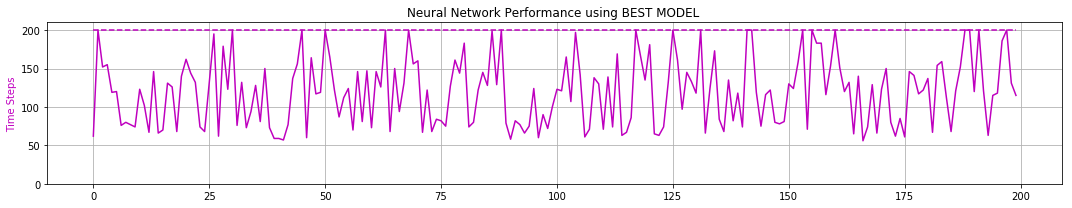

0 -max- [ 2.600  3.147  0.221  2.944]
0 -min- [-1.828 -3.321 -0.188 -2.552]

peak memory: 1838.20 MiB, increment: 976.87 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 2.600  3.220  0.216  2.851]
1 -min- [-1.829 -3.344 -0.188 -2.561]

peak memory: 1916.33 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 2.600  3.246  0.226  2.897]
2 -min- [-1.828 -3.320 -0.189 -2.533]

peak memory: 1838.20 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 2.600  3.234  0.227  2.919]
3 -min- [-1.828 -3.336 -0.189 -2.651]

peak memory: 1838.20 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 2.600  3.197  0.223  2.959]
4 -min- [-1.837 -3.341 -0.189 -2.571]

peak memory: 1838.20 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 2.600  3.260  0.218  2.905]
5 -min- [-1.835 -3.327 -0.190 -2.628]

peak memory: 1838.20 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 2.599  3.235  0.225  2.954]
6 -min- [-1.82

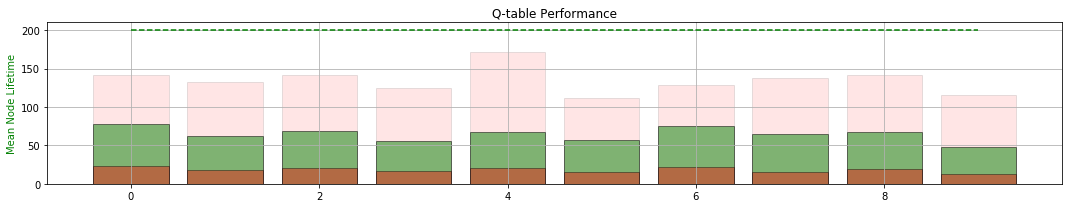

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 95.425	LOSS : 105.769	LOSS : 114.934	LOSS : 113.531	LOSS : 110.955	LOSS : 112.519	LOSS : 120.434	LOSS : 108.519	LOSS : 118.595	LOSS : 119.476	LOSS : 119.749	LOSS : 120.670	LOSS : 114.533	LOSS : 132.635	LOSS : 124.628	LOSS : 139.554	LOSS : 149.263	LOSS : 128.471	LOSS : 121.714	LOSS : 127.085	
Validating... MEAN TIME:  183.48
LOSS : 134.817	LOSS : 113.923	LOSS : 121.569	LOSS : 118.780	LOSS : 121.372	LOSS : 121.458	LOSS : 126.461	LOSS : 119.410	LOSS : 124.970	LOSS : 124.484	LOSS : 123.032	LOSS : 108.951	LOSS : 118.685	LOSS : 120.837	LOSS : 106.799	LOSS : 125.116	LOSS : 124.656	LOSS : 111.917	LOSS : 117.865	LOSS : 116.051	
Validating... MEAN TIME:  116.335
LOSS : 120.824	LOSS : 117.841	LOSS : 114.431	LOSS : 114.722	LOSS : 116.982	LOSS : 118.177	LOSS : 115.854	LOSS : 113.841	LOSS : 104.601	LOSS : 104.472	LOSS : 115.242	LOSS : 121.965	LOSS : 111.093	LOSS : 108.130	LOSS : 117.754	LOSS : 117.814	LOSS : 11

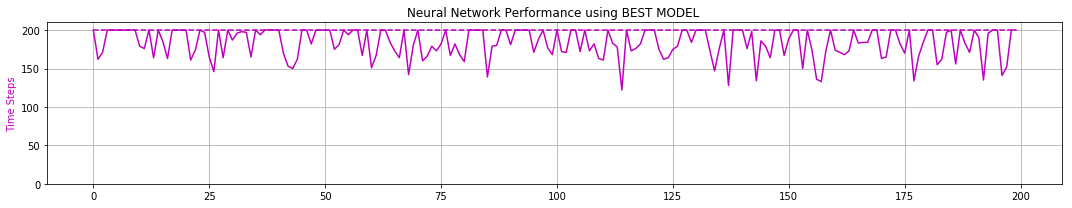

0 -max- [ 1.835  2.605  0.238  2.929]
0 -min- [-1.938 -3.492 -0.231 -2.594]

peak memory: 1831.43 MiB, increment: 976.91 MiB
Quantization TIME:  0.03 minutes
1 -max- [ 1.808  2.605  0.234  2.881]
1 -min- [-1.924 -3.561 -0.231 -2.681]

peak memory: 1831.46 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 1.803  2.550  0.240  2.975]
2 -min- [-1.924 -3.491 -0.231 -2.629]

peak memory: 1831.46 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 1.803  2.551  0.241  2.926]
3 -min- [-1.936 -3.542 -0.231 -2.646]

peak memory: 1831.46 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 1.823  2.922  0.239  3.046]
4 -min- [-1.934 -3.598 -0.231 -2.830]

peak memory: 1753.33 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 1.816  2.700  0.235  2.917]
5 -min- [-1.932 -3.563 -0.231 -2.750]

peak memory: 1831.46 MiB, increment: 976.94 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 1.813  2.545  0.240  2.923]
6 -min- [-1.94

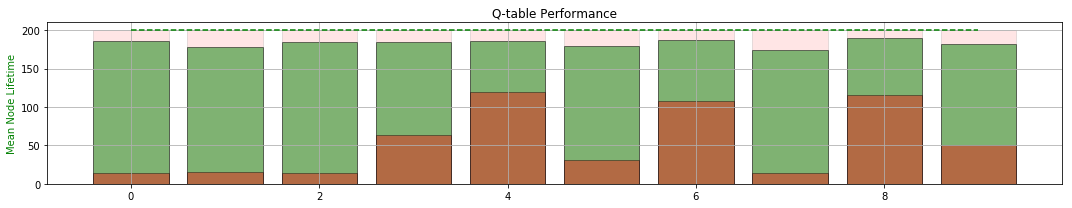

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 101.535	LOSS : 83.451	LOSS : 79.048	LOSS : 70.170	LOSS : 86.070	LOSS : 89.166	LOSS : 70.974	LOSS : 77.245	LOSS : 68.903	LOSS : 78.356	LOSS : 66.516	LOSS : 72.476	LOSS : 73.476	LOSS : 75.466	LOSS : 76.147	LOSS : 80.655	LOSS : 76.559	LOSS : 81.245	LOSS : 86.111	LOSS : 68.734	
Validating... MEAN TIME:  142.41
LOSS : 77.435	LOSS : 73.258	LOSS : 76.824	LOSS : 76.654	LOSS : 70.664	LOSS : 72.118	LOSS : 66.304	LOSS : 63.114	LOSS : 72.773	LOSS : 64.296	LOSS : 73.784	LOSS : 74.198	LOSS : 72.999	LOSS : 64.302	LOSS : 79.874	LOSS : 69.298	LOSS : 79.233	LOSS : 64.366	LOSS : 72.181	LOSS : 74.712	
Validating... MEAN TIME:  132.725
LOSS : 70.726	LOSS : 68.643	LOSS : 68.907	LOSS : 74.397	LOSS : 69.302	LOSS : 61.328	LOSS : 70.703	LOSS : 72.115	LOSS : 62.157	LOSS : 53.670	LOSS : 62.068	LOSS : 59.452	LOSS : 67.411	LOSS : 74.719	LOSS : 69.809	LOSS : 70.925	LOSS : 61.195	LOSS : 61.546	LOSS : 62.984	LOSS : 58.973	
Valida

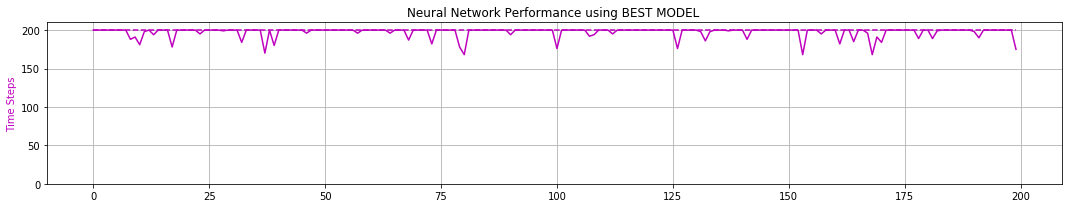

0 -max- [ 2.600  2.675  0.245  2.681]
0 -min- [-2.600 -3.644 -0.244 -2.550]

peak memory: 1805.23 MiB, increment: 970.40 MiB
Quantization TIME:  0.01 minutes
1 -max- [ 2.600  2.681  0.220  2.753]
1 -min- [-2.600 -3.746 -0.243 -2.607]

peak memory: 1811.80 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
2 -max- [ 2.600  2.631  0.247  2.738]
2 -min- [-2.600 -3.621 -0.245 -2.604]

peak memory: 1811.80 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
3 -max- [ 2.600  2.677  0.224  2.738]
3 -min- [-2.600 -3.714 -0.243 -2.716]

peak memory: 1889.93 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
4 -max- [ 2.600  2.932  0.249  2.867]
4 -min- [-2.600 -3.715 -0.245 -2.763]

peak memory: 1811.80 MiB, increment: 976.57 MiB
Quantization TIME:  0.01 minutes
5 -max- [ 2.600  2.749  0.220  2.795]
5 -min- [-2.600 -3.731 -0.243 -2.778]

peak memory: 1870.52 MiB, increment: 977.00 MiB
Quantization TIME:  0.01 minutes
6 -max- [ 2.600  2.639  0.236  2.738]
6 -min- [-2.60

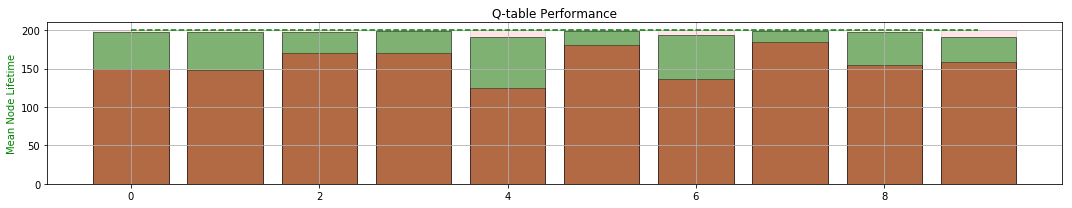

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        

    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    if iteration >= 4:
        for node_id in range(NO_OF_NODES):
            # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
            ###############################################
            [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
             C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]  = node_boundaries[node_id]
            ###############################################
            print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
            print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
            print("")

            # CREATE STATE COMBINATIONS
            ###############################################
            node_state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN],
                                                [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX],
                                                [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])
            ###############################################
            start = timeit.default_timer()
            # GET Q-VALUES 
            %memit q_table_list[node_id] = best_dqn.get_greedy_action(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
            stop = timeit.default_timer()
            print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
            #############################################################################################################################################

    else:
        for node_id in range(NO_OF_NODES):

            # PRINT STATE VALUE BORDERS AS REQUESTED BY THE NODE
            ###############################################
            [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
             C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]  = node_boundaries[node_id]
            ###############################################
            print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
            print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
            print("")
            #############################################################################################################################################
            node_state_combinations = init_state_combinations
            start = timeit.default_timer()
            # GET Q-VALUES 
            %memit q_table_list[node_id] = best_dqn.get_greedy_action(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
            node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                                    C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]
            stop = timeit.default_timer()
            print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
            #############################################################################################################################################

    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  1736.0
Total Serial Timesteps   :  1136859.0
Speed-up                 :  654.87


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9086 SUCCESS 125   9    1736    1136859     654.87


In [24]:
node_boundaries

array([[ 2.600,  2.729,  0.250,  2.391, -1.809, -2.739, -0.186, -2.131],
       [ 2.600,  2.912,  0.235,  2.319, -1.874, -2.830, -0.190, -2.131],
       [ 2.600,  2.969,  0.250,  2.385, -1.839, -2.733, -0.187, -2.126],
       [ 2.600,  2.677,  0.238,  2.315, -1.969, -2.794, -0.196, -2.234],
       [ 2.600,  3.149,  0.250,  2.478, -1.977, -2.831, -0.186, -2.228],
       [ 2.600,  2.998,  0.235,  2.385, -1.822, -2.808, -0.187, -2.339],
       [ 2.600,  2.886,  0.245,  2.318, -1.816, -2.791, -0.186, -2.117],
       [ 2.600,  2.607,  0.237,  2.303, -1.815, -2.770, -0.194, -2.330],
       [ 2.600,  2.981,  0.248,  2.357, -1.816, -2.832, -0.189, -2.109],
       [ 2.600,  2.668,  0.236,  2.232, -2.077, -2.783, -0.185, -2.098]])

In [26]:
node_max_time

array([ 200.000,  200.000,  200.000,  200.000,  200.000,  200.000,
        200.000,  200.000,  200.000,  200.000])

In [27]:
node_min_time

array([ 150.000,  148.000,  170.000,  170.000,  125.000,  180.000,
        136.000,  185.000,  155.000,  158.000])

In [28]:
node_avg_time

array([ 197.090,  197.000,  197.790,  199.000,  190.870,  198.360,
        193.430,  199.370,  198.010,  191.370])